### Project was peer-reviewed and validated by a Data Scientist
#### Dataset used in the project can be downloaded through Kaggle at https://www.kaggle.com/c/telstra-recruiting-network
# Objective of the project is to perform Bayesian Optimization and compare the findings with regular Grid Search and Randomized Grid Search.

# [Regular Grid Search]( https://gist.github.com/mohammadbutt/a58e41b5f0ce4f212bbcfea198b8148d )

# [Randomized Grid Search]( https://gist.github.com/mohammadbutt/a58e41b5f0ce4f212bbcfea198b8148d )

# 1. Import Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 2. All datasets of Telstra are imported. These datasets contain the information that will be used to analyze and predict service disruption.

In [2]:
data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')
log = pd.read_csv('log_feature.csv')
resource = pd.read_csv('resource_type.csv')
severity_type = pd.read_csv("severity_type.csv")
event = pd.read_csv("event_type.csv")

In [3]:
data_train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


# 3. Datasets are merged because it would help with analysis to have all the information at one place in a single DataFrame.

In [4]:
telstra = pd.merge(data_train, log, on ="id", how ="inner")
telstra = pd.merge(telstra, resource, on="id", how ="inner")
telstra = pd.merge(telstra, severity_type, on ="id", how = "inner")
telstra = pd.merge(telstra, event, on = "id", how = "inner")

In [5]:
telstra.head()

,id,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type
0,14121,location 118,1,feature 312,19,resource_type 2,severity_type 2,event_type 34
1,14121,location 118,1,feature 312,19,resource_type 2,severity_type 2,event_type 35
2,14121,location 118,1,feature 232,19,resource_type 2,severity_type 2,event_type 34
3,14121,location 118,1,feature 232,19,resource_type 2,severity_type 2,event_type 35
4,9320,location 91,0,feature 315,200,resource_type 2,severity_type 2,event_type 34


# 4. Text is removed from variables and then converted into integers. If the data is in integer type then dummies won't be created which makes the model run fast and helps create a baseline in less time by experiment multiple different things and doing feature engineering.

In [6]:
telstra['location'] = (telstra['location'].apply(lambda x: int(x.split(" ")[1])))
telstra['log_feature'] = telstra['log_feature'].apply(lambda x: int(x.split(" ")[1]))
telstra["resource_type"] = telstra["resource_type"].apply(lambda x: int(x.split(" ")[1]))
telstra["severity_type"] = telstra['severity_type'].apply(lambda x: int(x.split(" ")[1]))
telstra['event_type'] = telstra["event_type"].apply(lambda x: int(x.split(" ")[1]))

In [7]:
telstra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61839 entries, 0 to 61838
Data columns (total 8 columns):
id                61839 non-null int64
location          61839 non-null int64
fault_severity    61839 non-null int64
log_feature       61839 non-null int64
volume            61839 non-null int64
resource_type     61839 non-null int64
severity_type     61839 non-null int64
event_type        61839 non-null int64
dtypes: int64(8)
memory usage: 4.2 MB


In [8]:
telstra.corr()

,id,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type
id,1.000000,-0.026987,-0.045528,-0.014022,-0.003244,-0.014514,0.025929,0.025938
location,-0.026987,1.000000,0.270390,-0.280521,0.016999,0.451229,-0.365441,-0.399109
fault_severity,-0.045528,0.270390,1.000000,-0.208400,-0.027196,0.285475,-0.325157,-0.262184
log_feature,-0.014022,-0.280521,-0.208400,1.000000,-0.006759,-0.464366,0.303330,0.494708
volume,-0.003244,0.016999,-0.027196,-0.006759,1.000000,-0.045263,0.040748,0.061929
resource_type,-0.014514,0.451229,0.285475,-0.464366,-0.045263,1.000000,-0.340374,-0.614615
severity_type,0.025929,-0.365441,-0.325157,0.303330,0.040748,-0.340374,1.000000,0.364120
event_type,0.025938,-0.399109,-0.262184,0.494708,0.061929,-0.614615,0.364120,1.000000


In [9]:
telstra.head()

,id,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type
0,14121,118,1,312,19,2,2,34
1,14121,118,1,312,19,2,2,35
2,14121,118,1,232,19,2,2,34
3,14121,118,1,232,19,2,2,35
4,9320,91,0,315,200,2,2,34


In [10]:
telstra.describe()

,id,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type
count,61839.000000,61839.000000,61839.000000,61839.000000,61839.000000,61839.000000,61839.000000,61839.000000
mean,9104.379469,580.234836,0.549168,211.245411,8.390336,4.557334,1.441566,24.887482
std,5387.274195,318.089156,0.727701,94.919318,22.902491,2.863860,0.589572,12.007950
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4353.000000,304.000000,0.000000,134.000000,1.000000,2.000000,1.000000,13.000000
50%,8981.000000,607.000000,0.000000,228.000000,2.000000,2.000000,1.000000,23.000000
75%,13664.000000,834.000000,1.000000,306.000000,6.000000,8.000000,2.000000,35.000000
max,18550.000000,1126.000000,2.000000,384.000000,877.000000,10.000000,5.000000,54.000000


# 5.1 Feature Engineering - There are features that are repeated and when the groupby is done afterwards, that information will be lost. Count can also be obtained with groupby, but groupby will do the count and sum for all the features. But doing count and sum manually allows to get the information of just the columns that are needed.

# It's helpful to not do any feature engineering in the first draft. It is beneficial to create a baseline first. Feature engineering can be done after the first model has been constructed to compare the results and determine if feature engineering made the model better or not. 

In [11]:
telstra.head()

,id,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type
0,14121,118,1,312,19,2,2,34
1,14121,118,1,312,19,2,2,35
2,14121,118,1,232,19,2,2,34
3,14121,118,1,232,19,2,2,35
4,9320,91,0,315,200,2,2,34


In [12]:
telstra_id_count = pd.DataFrame(telstra.groupby('id')['id'].count())
telstra_location_count = pd.DataFrame(telstra.groupby('location')['location'].count())
telstra_log_count = pd.DataFrame(telstra.groupby('log_feature')['log_feature'].count())
telstra_severity_count = pd.DataFrame(telstra.groupby('severity_type')['severity_type'].count())
telstra_resource_count = pd.DataFrame(telstra.groupby('resource_type')['resource_type'].count())
telstra_event_count = pd.DataFrame(telstra.groupby('event_type')['event_type'].count())
telstra_volume_sum = pd.DataFrame(telstra.groupby('id')['volume'].sum())

# Rename the columns
telstra_id_count.rename(columns={'id':'id_count'}, inplace = True) # rename to id count
telstra_location_count.rename(columns={'location':'location_count'}, inplace = True) # rename to location count
telstra_log_count.rename(columns={'log_feature':'log_feature_count'}, inplace = True) # rename to log_feature_count
telstra_severity_count.rename(columns={'severity_type':'severity_type_count'}, inplace = True) # rename to severity_type_count
telstra_resource_count.rename(columns={'resource_type':'resource_type_count'}, inplace = True) # rename to resource_type_count
telstra_event_count.rename(columns={'event_type':'event_type_count'}, inplace = True) # rename to event_type_count
telstra_volume_sum.rename(columns={'volume':'volume_sum'}, inplace = True) # rename to volume sum

# 5.2 Feature Engineering – Dataframes with count and sum that were just created are joined on to the original DataFrame.

In [13]:
telstra = telstra.join(telstra_id_count, on='id')
telstra = telstra.join(telstra_location_count, on='location')
telstra = telstra.join(telstra_volume_sum, on='id')
telstra = telstra.join(telstra_log_count, on ='log_feature')
telstra = telstra.join(telstra_severity_count, on = 'severity_type')
telstra = telstra.join(telstra_resource_count, on = 'resource_type')
telstra = telstra.join(telstra_event_count, on = 'event_type')

# 5.3 Feature Engineering – Features are multiplied by other features to get a product.  This is an experimental attempt to create new features from the existing features. 

# And feature engineering like this would help on the second or third model to compare the performance and scores with the baseline model.

In [14]:
#product_of_id_location = after_groupby['id_count']*after_groupby['location_count']
#sum_of_id_location = after_groupby['id_count']+after_groupby['location_count']
#after_groupby['id_location_score'] = 2*((product_of_id_location)/(sum_of_id_location))

telstra['id_location_product'] = telstra['id_count']*telstra['location_count']
telstra['id_location_volume_product']=telstra['id_count']*telstra['location_count']*telstra['volume_sum']
#telstra['volume_location_product'] = telstra['volume_sum']*telstra['location_count']


telstra['log_feature_per_id'] = telstra['log_feature_count']/telstra['id_count']
telstra['severity_per_id'] = telstra['severity_type_count']/telstra['id_count']
telstra['resource_per_id'] = telstra['resource_type_count']/telstra['id_count']
telstra['event_per_id'] = telstra['event_type_count']/telstra['id_count']
telstra['volume_per_id'] = telstra['volume_sum']/telstra['id_count']
telstra['location_per_id'] = telstra['location_count']/telstra['id_count']

In [15]:
telstra.head()

,id,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type,id_count,location_count,...,resource_type_count,event_type_count,id_location_product,id_location_volume_product,log_feature_per_id,severity_per_id,resource_per_id,event_per_id,volume_per_id,location_per_id
0,14121,118,1,312,19,2,2,34,4,207,...,31746,11390,828,62928,1133.50,6065.0,7936.5,2847.50,19.0,51.75
1,14121,118,1,312,19,2,2,35,4,207,...,31746,11989,828,62928,1133.50,6065.0,7936.5,2997.25,19.0,51.75
2,14121,118,1,232,19,2,2,34,4,207,...,31746,11390,828,62928,1050.00,6065.0,7936.5,2847.50,19.0,51.75
3,14121,118,1,232,19,2,2,35,4,207,...,31746,11989,828,62928,1050.00,6065.0,7936.5,2997.25,19.0,51.75
4,9320,91,0,315,200,2,2,34,4,408,...,31746,11390,1632,1031424,312.25,6065.0,7936.5,2847.50,158.0,102.00


In [16]:
telstra.nunique()

id                            7381
location                       929
fault_severity                   3
log_feature                    331
volume                         254
resource_type                   10
severity_type                    5
event_type                      49
id_count                        67
location_count                 221
volume_sum                     485
log_feature_count              144
severity_type_count              5
resource_type_count             10
event_type_count                43
id_location_product           1244
id_location_volume_product    3925
log_feature_per_id            1934
severity_per_id                114
resource_per_id                302
event_per_id                   689
volume_per_id                  738
location_per_id               1198
dtype: int64

# 6. Visualizing data - Visualizing data is a good way to identify outliers or typos. Below histograms and boxplot have outliers. But there doesn't seem to be outliers so no changes are made to it.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014A5388F048>]],
      dtype=object)

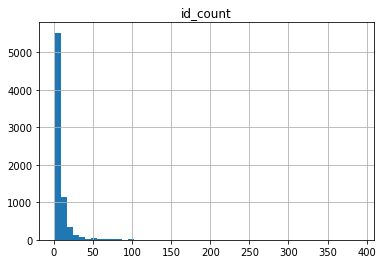

In [17]:
telstra_id_count.hist(bins = 50) 

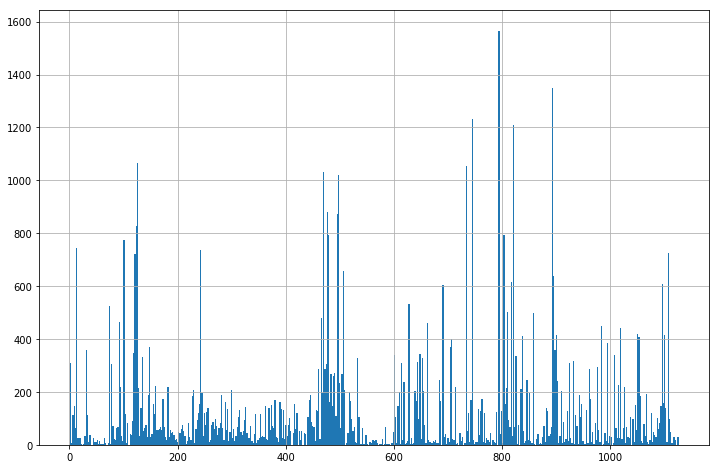

In [18]:
#plt.figure(figsize=(6,4)) - original scale
plt.figure(figsize=(12,8))
telstra.location.hist(bins = 500)

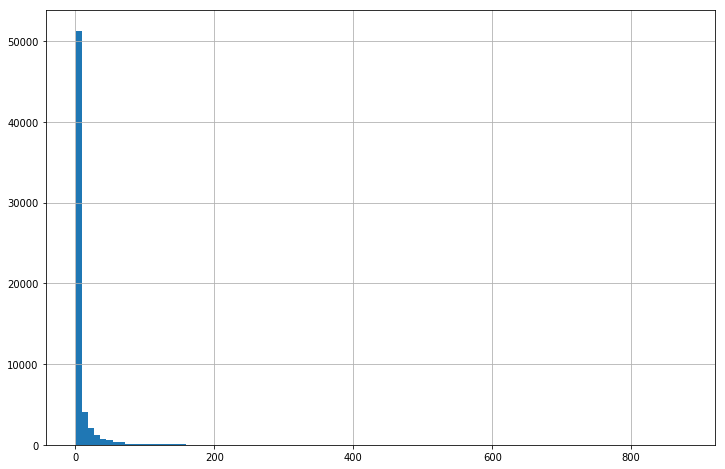

In [19]:
plt.figure(figsize=(12,8))
telstra.volume.hist(bins =100)

{'whiskers': [<matplotlib.lines.Line2D at 0x14a55a24c50>,
 'caps': [<matplotlib.lines.Line2D at 0x14a55a2d550>,
 'boxes': [<matplotlib.lines.Line2D at 0x14a55a24b00>],
 'medians': [<matplotlib.lines.Line2D at 0x14a55a2dda0>],
 'fliers': [<matplotlib.lines.Line2D at 0x14a55a35208>],
 'means': []}

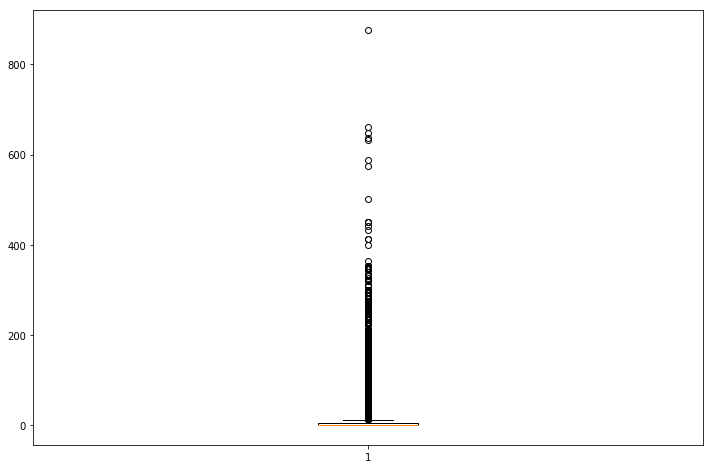

In [20]:
plt.figure(figsize=(12,8))
plt.boxplot(telstra['volume'])

# 6. This would be a good place to create dummies. If dummies are created, location should be skipped because the dimensions for the test dataset will not match afterwards because there are more unique locations in test dataset than training dataset. But no Dummies are created because text or object features were already converted to integer/numerical.  And not creating dummies is a good way to experiment several things in less time because dummies create more columns and running that is computationally expensive at experimental stage or baseline model.

In [21]:
#after_dummies = pd.get_dummies(telstra,drop_first = True)

In [22]:
#after_dummies

# 7. Groupby on id because each id appears several different times and groupby will consolidate information of each id into one.

In [23]:
after_groupby = telstra.groupby(telstra.id, sort = False).max()
after_groupby.head()

,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type,id_count,location_count,volume_sum,...,resource_type_count,event_type_count,id_location_product,id_location_volume_product,log_feature_per_id,severity_per_id,resource_per_id,event_per_id,volume_per_id,location_per_id
id,,,,,,,,,,,,,,,,,,,,,
14121,118,1,312,19,2,2,35,4,207,76,...,31746,11989,828,62928,1133.500000,6065.000000,7936.500000,2997.250000,19.000000,51.750000
9320,91,0,315,200,2,2,35,4,408,632,...,31746,11989,1632,1031424,312.250000,6065.000000,7936.500000,2997.250000,158.000000,102.000000
14394,152,1,301,1,2,2,35,4,20,4,...,31746,11989,80,320,191.250000,6065.000000,7936.500000,2997.250000,1.000000,5.000000
8218,931,1,203,12,8,1,15,6,291,44,...,20005,13125,1746,76824,393.166667,6095.166667,3334.166667,2187.500000,7.333333,48.500000
14804,120,0,237,2,8,1,36,72,129,96,...,31746,13125,9288,891648,58.333333,507.930556,440.916667,182.291667,1.333333,1.791667


In [24]:
after_groupby.isnull().sum()[after_groupby.isnull().sum()>0]

Series([], dtype: int64)

In [25]:
after_groupby[after_groupby.fault_severity == 0].head()

,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type,id_count,location_count,volume_sum,...,resource_type_count,event_type_count,id_location_product,id_location_volume_product,log_feature_per_id,severity_per_id,resource_per_id,event_per_id,volume_per_id,location_per_id
id,,,,,,,,,,,,,,,,,,,,,
9320,91,0,315,200,2,2,35,4,408,632,...,31746,11989,1632,1031424,312.250000,6065.000000,7936.500000,2997.250000,158.000000,102.000000
14804,120,0,237,2,8,1,36,72,129,96,...,31746,13125,9288,891648,58.333333,507.930556,440.916667,182.291667,1.333333,1.791667
1080,664,0,171,8,8,1,11,2,14,16,...,20005,13125,28,448,242.500000,18285.500000,10002.500000,6562.500000,8.000000,7.000000
9731,640,0,374,3,2,4,50,1,7,3,...,31746,233,7,21,122.000000,920.000000,31746.000000,233.000000,3.000000,7.000000
15505,122,0,315,5,2,2,35,12,720,28,...,31746,11989,8640,241920,377.833333,2021.666667,2645.500000,999.083333,2.333333,60.000000


In [26]:
after_groupby[after_groupby.fault_severity == 1].head()

,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type,id_count,location_count,volume_sum,...,resource_type_count,event_type_count,id_location_product,id_location_volume_product,log_feature_per_id,severity_per_id,resource_per_id,event_per_id,volume_per_id,location_per_id
id,,,,,,,,,,,,,,,,,,,,,
14121,118,1,312,19,2,2,35,4,207,76,...,31746,11989,828,62928,1133.500000,6065.000000,7936.500000,2997.25,19.000000,51.75
14394,152,1,301,1,2,2,35,4,20,4,...,31746,11989,80,320,191.250000,6065.000000,7936.500000,2997.25,1.000000,5.00
8218,931,1,203,12,8,1,15,6,291,44,...,20005,13125,1746,76824,393.166667,6095.166667,3334.166667,2187.50,7.333333,48.50
3443,263,1,312,1,2,2,35,4,40,4,...,31746,11989,160,640,1133.500000,6065.000000,7936.500000,2997.25,1.000000,10.00
13300,613,1,82,30,8,1,54,4,247,62,...,20005,5475,988,61256,589.750000,9142.750000,5001.250000,1368.75,15.500000,61.75


In [27]:
after_groupby[after_groupby.fault_severity == 2].head()

,location,fault_severity,log_feature,volume,resource_type,severity_type,event_type,id_count,location_count,volume_sum,...,resource_type_count,event_type_count,id_location_product,id_location_volume_product,log_feature_per_id,severity_per_id,resource_per_id,event_per_id,volume_per_id,location_per_id
id,,,,,,,,,,,,,,,,,,,,,
4311,704,2,203,20,8,1,15,12,354,102,...,20005,13125,4248,433296,196.583333,3047.583333,1667.083333,1093.750000,8.500000,29.500000
12261,1089,2,170,17,8,1,11,3,20,29,...,20005,13125,60,1740,580.000000,12190.333333,6668.333333,4375.000000,9.666667,6.666667
14992,600,2,203,2,8,2,15,2,176,3,...,20005,5475,352,1056,1179.500000,12130.000000,10002.500000,2737.500000,1.500000,88.000000
967,892,2,376,6,2,1,44,18,405,81,...,31746,967,7290,590490,29.444444,2031.722222,1763.666667,53.722222,4.500000,22.500000
3945,684,2,203,44,8,2,15,3,243,63,...,20005,5475,729,45927,786.333333,8086.666667,6668.333333,1825.000000,21.000000,81.000000


In [28]:
after_groupby.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7381 entries, 14121 to 17067
Data columns (total 22 columns):
location                      7381 non-null int64
fault_severity                7381 non-null int64
log_feature                   7381 non-null int64
volume                        7381 non-null int64
resource_type                 7381 non-null int64
severity_type                 7381 non-null int64
event_type                    7381 non-null int64
id_count                      7381 non-null int64
location_count                7381 non-null int64
volume_sum                    7381 non-null int64
log_feature_count             7381 non-null int64
severity_type_count           7381 non-null int64
resource_type_count           7381 non-null int64
event_type_count              7381 non-null int64
id_location_product           7381 non-null int64
id_location_volume_product    7381 non-null int64
log_feature_per_id            7381 non-null float64
severity_per_id               7381 n

In [29]:
after_groupby.corr().fault_severity.sort_values(ascending = False)

fault_severity                1.000000
resource_type                 0.332234
location                      0.273488
severity_type_count           0.220740
id_count                      0.078218
id_location_product           0.053321
location_count                0.053096
volume                        0.037689
location_per_id               0.033934
id_location_volume_product    0.023308
volume_sum                    0.022345
severity_per_id               0.011108
volume_per_id                -0.010361
log_feature_per_id           -0.077740
event_per_id                 -0.103127
event_type_count             -0.116985
log_feature                  -0.124616
resource_per_id              -0.141397
log_feature_count            -0.147178
event_type                   -0.180440
severity_type                -0.215521
resource_type_count          -0.269632
Name: fault_severity, dtype: float64

# 8.1 Creating a model – Features are assigned to x and y. All the features are assigned to x, except fault severity because that's the target variable, which is assigned to y.

In [30]:
y = data_train['fault_severity']
del after_groupby['fault_severity']
x = after_groupby

# 8.2. This project doesn’t use feature scaling (normalization or standardization) because I was not aware of feature scaling when the project was done in April. 

# Feature scaling takes all the numbers and scales them between (0 and 1), (-1 and 1), or some other similar range. Feature scaling is useful because it gives equal weight to all the features. Feature scaling is helpful in converging the model fast and finding the local minimum. Below is how feature scaling can be used. x_scaled will replace x when train_test_split is done. And x will be replaced again with x_scaled when cross-validation is done.

In [31]:
#from sklearn.preprocessing import maxabs_scale
#x_scaled = maxabs_scale(x, axis=0, copy = True)  #x range [-1,1]

In [32]:
#from sklearn.preprocessing import minmax_scale
#x_scaled = minmax_scale(x, feature_range=(0,1), axis=0, copy=True)

# 9. Train Test Split – Data is split in train and test for x and y, x_train is used to train the model which has all the features except fault_severity. y_train has fault_severity. 

In [33]:
from sklearn.model_selection import train_test_split as tts
#x_train,  x_test, y_train, y_test = tts(x_scaled, y, test_size = 0.2, random_state= 0, stratify = y)

x_train,  x_test, y_train, y_test = tts(x, y, test_size = 0.2, random_state= 0)

# 10. Import Algorithm

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [35]:
dt = DecisionTreeClassifier(random_state = 0)
rf = RandomForestClassifier(random_state = 0)
gb = GradientBoostingClassifier(random_state = 0)
kn = KNeighborsClassifier(n_neighbors = 5)

# 11. Fit the data. x_train and y_train are used together to train the model.

In [36]:
dtr = dt.fit(x_train, y_train)
rfr = rf.fit(x_train, y_train)
gbr = gb.fit(x_train, y_train)
knn = kn.fit(x_train, y_train)

# 12. Printing matrices to see what the scores are for training and testing. Maximum score is 1 or 100, if multiplied by 100. A higher score is good, but scores will be cross validated later, which is a better way of determining how good a model really is on the entire dataset.

In [37]:
print("Decision Tree training score", dtr.score(x_train, y_train))
print("Random Forest training score", rfr.score(x_train, y_train))
print("Gradient Boosting train score:", gbr.score(x_train, y_train))
print("KNeighbors training score", knn.score(x_train, y_train))


Decision Tree training score 0.9983062330623306
Random Forest training score 0.9830623306233063
Gradient Boosting train score: 0.785230352303523
KNeighbors training score 0.7654132791327913


In [38]:
print("Decision Tree test score", dtr.score(x_test, y_test))
print("Random Forest test score", rfr.score(x_test, y_test))
print("Gradient Boosting test score:", gbr.score(x_test, y_test))
print("KNeighbors test score", knn.score(x_test, y_test))


Decision Tree test score 0.6953283683141503
Random Forest test score 0.7379823967501693
Gradient Boosting test score: 0.7535545023696683
KNeighbors test score 0.6716316858496953


# 13. Accuracy

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
d_predict = dt.predict(x_test)
r_predict = rf.predict(x_test)
g_predict = gb.predict(x_test)
k_predict = kn.predict(x_test)


In [41]:
print("Decision tree:", accuracy_score(y_test, d_predict))
print("Random Forest:", accuracy_score(y_test, r_predict))
print("Gradient Boosting:", accuracy_score(y_test, g_predict))
print("KNeighbors:", accuracy_score(y_test, k_predict))

Decision tree: 0.6953283683141503
Random Forest: 0.7379823967501693
Gradient Boosting: 0.7535545023696683
KNeighbors: 0.6716316858496953


# 14. Cross Validation is used to see what the scores are after the K-Folds or partitions have been done of the dataset. Because a certain training or testing dataset could have bias, noise, or outliers which can skew the results. Doing cross validation allows the entire data to have gone through training, more importantly the whole dataset goes through testing and then the scores of the tests are averaged out by the number of K-folds and partitions.

In [42]:
from sklearn.model_selection import cross_val_score
print("Decision Tree:", cross_val_score(dt, x, y, cv=10, scoring = "accuracy").mean())
print("Random Forest:", cross_val_score(rf, x, y, cv=10, scoring = "accuracy").mean())
print("Gradient Bossting:", cross_val_score(gb, x, y, cv=10, scoring = "accuracy").mean())
print("KNeighbors:", cross_val_score(kn, x, y, cv=10, scoring = "accuracy").mean())

Decision Tree: 0.7054646173037156
Random Forest: 0.7337837267316887
Gradient Bossting: 0.7429882867409129
KNeighbors: 0.6705156668988783


# 15. Importance of features

In [43]:
feature_importances_dt = pd.DataFrame(dt.feature_importances_, index = x.columns,
                                     columns=["Importance"]).sort_values ("Importance", ascending = False)
feature_importances_dt

,Importance
log_feature,0.127786
location,0.122235
volume_per_id,0.121448
id_location_volume_product,0.098109
location_per_id,0.072871
resource_type,0.067337
volume_sum,0.065384
location_count,0.054385
volume,0.051950
log_feature_per_id,0.049423


In [44]:
feature_importances_rf = pd.DataFrame(rf.feature_importances_, index = x.columns,
                                     columns=["Importance"]).sort_values ("Importance", ascending = False)
feature_importances_rf

,Importance
location,0.100968
volume_per_id,0.085561
id_location_volume_product,0.084959
log_feature,0.081675
location_per_id,0.074778
volume_sum,0.068839
volume,0.068163
location_count,0.065769
id_location_product,0.063525
log_feature_count,0.049626


In [45]:
feature_importances_gb = pd.DataFrame(gb.feature_importances_, index = x.columns,
                                     columns=["Importance"]).sort_values ("Importance", ascending = False)
feature_importances_gb

,Importance
log_feature,0.151997
location,0.144710
volume_per_id,0.074608
location_per_id,0.068170
volume_sum,0.056496
log_feature_count,0.053650
log_feature_per_id,0.049927
event_type,0.049874
id_location_product,0.045629
severity_per_id,0.042231


In [46]:
gb.predict(x)

array([0, 0, 0, ..., 2, 0, 0], dtype=int64)

In [47]:
#checkpoint

## Bayesian Optimization – Just like Randomized GridSearch, Bayesian Optimization is much more controlled because of number of iterations that the search will go on for. The Below Bayesian Optimization has same range and parameters as Randomized Grid Search, but min_samples_split and min_samples_leaf increase by an increment of 2 in Randomized GridSearch, but in Bayesian Optimization these parameters increase with an increment of 1 and this gives 6,720 different combinations in Bayesian Optimization, but the search will only do 300 iterations. Unlike Grid Search and Randomized Grid Search, Bayesian optimization learns from best parameters to improve the model, which is why it will often run all of the same parameters leading to user warning that "the objective has been evaluated." However, Bayesian Optimization does not learn anything from a bad model or a model which has parameters with low scores.

In [48]:
from skopt import BayesSearchCV

In [49]:
%%time
param_dist = {'min_samples_split':(2,8), 'min_samples_leaf':(1,5),
              "max_depth":(3,5), "subsample": [0.6,0.7,0.75,0.8,0.85,0.9,1.0],
               'learning_rate': [0.01,0.03,0.06,0.09,0.1,0.3,0.6,0.9]}
opt_search = BayesSearchCV(gb, param_dist, n_iter =300, n_jobs =4, iid=False, verbose = 0, random_state = 0,
                            return_train_score = False)
opt_search.fit(x, y)

C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: Th

C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: Th

C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: Th

C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: Th

C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: Th

C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: Th

C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: Th

C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\maniq\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: Th

Wall time: 49min 26s


In [50]:
#opt_search.grid_scores_,opt_search.best_params_,opt_search.best_score_
print(opt_search.best_score_)
print(opt_search.best_params_)

0.7539634290595484
{'learning_rate': 0.06, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'subsample': 0.9}


In [53]:
gb_param = GradientBoostingClassifier(learning_rate = 0.06, max_depth = 5, min_samples_leaf = 5,
                                     min_samples_split = 2, subsample = 0.9)
print("Gradient Bossting:", cross_val_score(gb_param, x, y, cv=10, scoring = "accuracy").mean())

Gradient Bossting: 0.7543720711842707


## Concluding words: Cross Validation score without changing any parameters is 0.74298, but the Cross-Validation score with the parameters that were found with Basyesian Optimization is 0.75437. This makes the model more reliable by 1.14% and it took 49 minutes to achieve this result. Between regular Grid Search and Bayesian Optimization, one can benefit from using Bayesian Optimization because it took 40 minutes less to train the model and find the best parameters and regular Grid Search only did better by 0.04%. Bayesian Optimization also gives the freedom and flexibility to run fewer iterations compared to regular GridSearch which will run all possible combinations again which can be computationally expensive if there are tens of thousands of combinations with more data. Randomized GridSearch took the least amount of time to find the best parameters which is impressive. 
## One area to explore would be to run Randomized GridSearch and Bayesian Optimization with more parameters and range, but with fewer iterations possibly 10 to 50 and then compare those results. Another area to explore would be to not have a random state which could be beneficial for Bayesian Optimization since it learns from a good model and best parameters. 
## Between Randomized GridSearch and Bayesian Optimization, more tests would have to be conducted on different datasets with different algorithms, more parameters and range to examine which search method outperforms the other.

# [Regular Grid Search]( https://gist.github.com/mohammadbutt/a58e41b5f0ce4f212bbcfea198b8148d )

# [Randomized Grid Search]( https://gist.github.com/mohammadbutt/a58e41b5f0ce4f212bbcfea198b8148d )